In [1]:
# Model laden
from tensorflow import keras
model = keras.models.load_model('models/sliding_window/sw_rnn_a_cv_5f_64n/')

In [2]:
# Benötigte Libraries importieren
import cv2
import mediapipe as mp
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [8]:
# Zeichnen der Landmarks
mp_drawing = mp.solutions.drawing_utils
# Erkennen der Landmarks
mp_pose = mp.solutions.pose

# Aus True setzen, falls die Person Linkshänder ist oder das Bild gespiegelt ist.
flip_image = False

# Sequenz der zu klassifizierenden Landmarks
sequence = []
# Predictions jedes Sliding Windows
predictions = []
# Threshold für die Klassifizierung
threshold = 0.5
# String, welcher dem Benutzenden im Bild angezeigt wird
prediction = ''

# Gewünschte Window-Size (kann auch grösser sein als die des verwendeten Modells)
n_frames = 20

# Bei mehreren Webcams kann hier die Nummer angepasst werden
cap = cv2.VideoCapture(0)

# Writer für das Aufzeichnen und Speichern eines Videos
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
writer = cv2.VideoWriter('trink_video.mp4', cv2.VideoWriter_fourcc(*'DIVX'), 20, (width,height))

# Set mediapipe model 
with mp_pose.Pose(
                min_detection_confidence=0.5,
                min_tracking_confidence=0.5) as pose:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        
        if flip_image:
            frame = cv2.flip(frame, 1)
        
        # Landmarks lesen und speichern
        results = pose.process(frame)
        pose_landmarks = results.pose_landmarks
        
        # Landmarks auf den Frame zeichnen
        mp_drawing.draw_landmarks(frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS, 
                                 mp_drawing.DrawingSpec(color=(0,0,255), thickness=2, circle_radius=4), 
                                 mp_drawing.DrawingSpec(color=(255,255,255), thickness=2, circle_radius=2))
        
        # Falls Landmarks erkannt wurden, werden diese der zu klassifizierenden Sequenz hinzugefügt
        if pose_landmarks is not None:
            # Get landmarks
            frame_height, frame_width = frame.shape[0], frame.shape[1]
            pose_landmarks = np.array(
                [[lmk.x * frame_width, lmk.y * frame_height, lmk.z * frame_width]
                 for lmk in pose_landmarks.landmark],
                dtype=np.float32).flatten()
            sequence.append(list(pose_landmarks))
            # Die Sequenz hat jeweils nur die Länge der gesetzen Window-Länge (n_frames)
            sequence = sequence[-n_frames:]

        # Wenn die gesetze Länge erreicht wurde, wird mit der Modell eine Kompensationswahrscheinlichkeit berechnet.
        if len(sequence) == n_frames:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            predictions.append(res)
            if res < threshold:
                prediction = 'Natural'
            else:
                prediction = 'Kompensation'
            
            # Rechteck und Text auf Frame schreiben
            frame = cv2.rectangle(frame, (5, 5), (350, 60), (0, 0, 0), -1)
            cv2.putText(frame, ' '.join(prediction), (9,25), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA)
            cv2.putText(frame, str(round(100*res[0], 2))+'% Kompensationswahrscheinlichkeit', (9,50), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
        
        # Frame in aufgezeichnetes Video speichern
        writer.write(frame)
        
        # Frame im Fenster anzeigen 
        cv2.imshow('Real Time Kompensationserkennung', frame)

        # Fenster schliessen, wenn 'q' gedrückt wird
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    writer.release()
    cv2.destroyAllWindows()

In [9]:
print("Anteil der Kompensation während des Trinkvorganges: %.2f%%" % (np.mean(predictions)*100))

Anteil der Kompensation während des Trinkvorganges: 85.70%


Text(0, 0.5, 'Kompensationswahrscheinlichkeit')

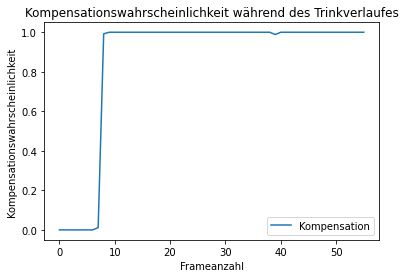

In [10]:
'''
Hier wird der zeitliche Verlauf der Kompensastionswahrscheinlichkeit grafisch dargestellt.
'''
plt.plot(predictions, label="Kompensation")
plt.legend()
plt.title(label="Kompensationswahrscheinlichkeit während des Trinkverlaufes")
plt.xlabel('Frameanzahl')
plt.ylabel('Kompensationswahrscheinlichkeit')